<a href="https://colab.research.google.com/github/Nannanpeng/Treaty_Game/blob/master/Profits_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Data simulation for treaty game
## <center> ---- model for player profits
## There are several conclusions from this simlutaion.
* The data simulation shows that the profits have high variances. 
It indicates we might want to average the payoffs for the subjects
in the lab. 
* The profits of each player (or the total profits) seems to follow
some 'geometric' or 'exponential' distribution. That's not a surprise 
since the periods of the experiment are drawn from geometric distribution.
* After scaling down the profits, I can fit the profits with a geometric
or a exponential model. And the exponential model seems to be better if we focus on the mean.
* Unfortunately, the simulation cannt add treaties, which is hard to do here. 

In [1]:
!pip install --upgrade pymc3==3.8
!pip install arviz

     |████████████████████████████████| 911kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 51.0MB/s 
     |████████████████████████████████| 4.3MB 49.8MB/s 
     |████████████████████████████████| 296kB 53.0MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [32]:
import numpy as np
import pandas as pd
from scipy.special import expit
import certainty_and_uncertainty as model
from scipy.stats import geom
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import pymc3.distributions.transforms as tr

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


# Data Generation
Note: It will take some time to generate the simulated profits. 
You can skip it as I have generated some toy data you can 
play with. 

In [3]:
n = 200
prob = 1/6
default_certainty_periods = 10
n_initial_land = 65

In [ ]:
ie = model.IncomeExpansion(120, 0.045, 18, 180, 0.065, 40, 8, 30, 100, 0.5, 0.5)
pd_ = model.PlayerDecision(ie, prob, default_certainty_periods)
dp = model.DP(ie, pd_)
certainty_periods = geom.rvs(prob, size=200)

In [ ]:
%%time

simulation_res = []
for period in certainty_periods:
  res = dp.Simulation(n_initial_land, period)
  simulation_res.append(res)

CPU times: user 41min 15s, sys: 35.3 s, total: 41min 50s
Wall time: 40min 32s


In [ ]:
simulation_data = pd.DataFrame(simulation_res, columns=['TotalPeriods', 'NativeProfit', 'SettlerProfit'])

In [ ]:
simulation_data.to_csv('simulation_profit.csv', index=False)

# Data Analysis

##1. Descriptive statistics and visualization

In [4]:
profits = pd.read_csv('simulation_profit.csv')
profits.describe()

,TotalPeriods,NativeProfit,SettlerProfit
count,200.000000,200.000000,200.000000
mean,16.385000,862.476350,1154.910350
std,6.252378,340.071984,619.801098
min,11.000000,562.080000,607.240000
25%,12.000000,624.127500,718.542500
50%,14.000000,735.505000,927.835000
75%,18.000000,955.530000,1335.842500
max,52.000000,2797.550000,4719.530000


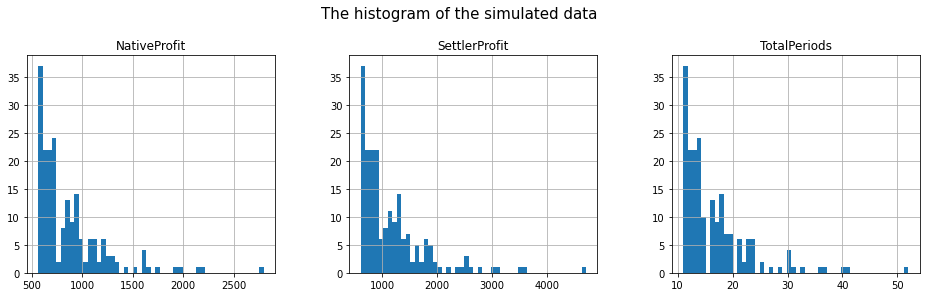

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
profits.hist(ax=axes, bins=50)
fig.suptitle('The histogram of the simulated data', y=1.05, size=15);

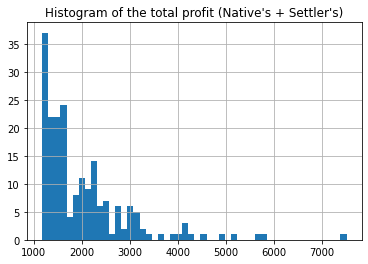

In [6]:
plt.hist(profits.NativeProfit+profits.SettlerProfit, bins=50)
plt.title("Histogram of the total profit (Native's + Settler's)")
plt.grid();

##2 Different models

### 1). Geometric model

In [36]:
def GeometricModel(data):
  with pm.Model() as model:
      betas = pm.Normal('betas', 0, 10, shape=2)
      p = 1/(1 + np.exp(-(betas[0] + betas[1] * data['IfSettler'])))
      obs = pm.Geometric('obs', p, observed=data['Profits'])
      trace = pm.sample(2000, tune=1000, chains=2, cores=2)    
  return trace, model

In [37]:
data_sim = np.row_stack((profits.SettlerProfit, profits.NativeProfit)).flatten()/500
data_sim = pd.DataFrame(data_sim, columns=['Profits'])
data_sim['IfSettler'] = [1]*n + [0]*n

In [38]:
trace_1, model_1 = GeometricModel(data_sim)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 763.18draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [39]:
res1 = pm.summary(trace_1)
res1

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],1.142,0.151,0.859,1.419,0.005,0.003,940.0,940.0,938.0,1385.0,1.01
betas[1],-0.957,0.185,-1.305,-0.612,0.006,0.005,826.0,826.0,824.0,1453.0,1.01


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


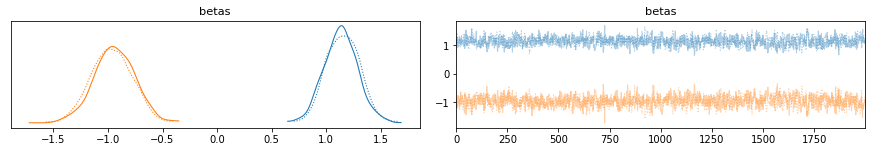

In [40]:
pm.traceplot(trace_1);

In [41]:
n_p = expit(res1.iloc[0,0])
s_p = expit(res1.iloc[0,0] + res1.iloc[1,0]) 
print('The geometric mean for Native is: {:.3f}.'.format((1-n_p)/n_p))
print('The geometric mean for Settler is: {:.3f}.'.format((1-s_p)/s_p))

The geometric mean for Native is: 0.319.
The geometric mean for Settler is: 0.831.


### 2). Exponential model

In [43]:
def ExponentialModel(data):
   with pm.Model() as model:
      betas = pm.Uniform('betas', 0, 10, shape=2)
      lam = betas[0] + betas[1] * data['IfSettler']
      obs = pm.Exponential('obs', lam, observed=data['Profits'])
      trace = pm.sample(2000, tune=1000, chains=2, cores=2)    
   return trace, model

In [44]:
trace_2, model_2 = ExponentialModel(data_sim)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 10 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1072.15draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [45]:
res2 = pm.summary(trace_2)
res2

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],0.490,0.026,0.441,0.537,0.001,0.0,1945.0,1945.0,1925.0,1284.0,1.0
betas[1],0.014,0.013,0.000,0.040,0.000,0.0,1970.0,1970.0,1508.0,1332.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


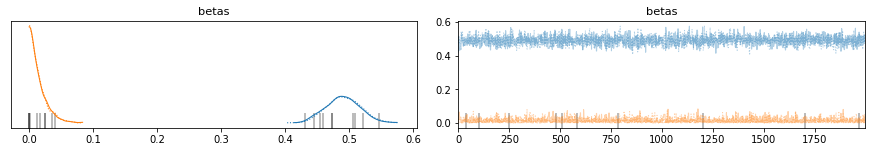

In [46]:
pm.traceplot(trace_2);

In [47]:
print('The exponential mean for Native is: {:.3f}.'.format(1/res2.iloc[0, 0]))
print('The exponential mean for Settler is: {:.3f}.'.format(1/(res2.iloc[0, 0]+res2.iloc[1, 0])))

The exponential mean for Native is: 2.041.
The exponential mean for Settler is: 1.984.
